In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import datetime

/Users/danielmpfeffer/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# 1985:Q1 to 2019:Q4
start = datetime.datetime(1985, 1, 1)
end = datetime.datetime(2019, 12, 31)

# Quarterly U.S. real GDP from the FRED
ts = web.DataReader('GDPC1', 'fred', start, end)

In [4]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Add constant
ts = sm.add_constant(ts)

# Add trend variable 
ts['trend'] = ts.const.cumsum()

# Log transformation
ts['y'] = np.log(ts['GDPC1'])

# Add lag term
ts['y_lag1'] = ts['y'].shift()

# Drop first observation
ts = ts[1:]

In [5]:
# Fit model by OLS
mod = sm.OLS(ts['y'], ts[['const', 'trend', 'y_lag1']])
res = mod.fit()
print(summary_col(res, stars=True, float_format='%0.3f').as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lc}
\hline
          &    y      \\
\midrule
const     & 0.116     \\
          & (0.104)   \\
trend     & 0.000     \\
          & (0.000)   \\
y\_lag1   & 0.988***  \\
          & (0.012)   \\
R-squared & 1.000     \\
          & 1.000     \\
\hline
\end{tabular}
\end{center}
\end{table}


In [6]:
beta1 = res.params.values[0]
beta2 = res.params.values[1]
beta3 = res.params.values[2]
y = [ts['y'][0]]
for t in range(1, len(ts)):
    y.append(beta1 + beta2*ts['trend'][t] + beta3*y[t-1])
    
y_tilde =  beta1 + beta2*ts['trend']

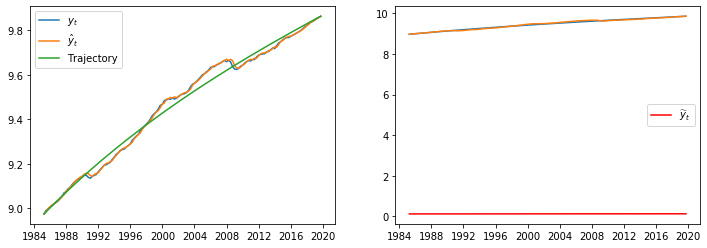

In [7]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(mod.data.orig_endog, label='$y_t$')
ax1.plot(res.fittedvalues, label='$\hat y_t$')
ax1.plot(ts.index, y, label='Trajectory')
ax1.legend()

ax2.plot(ts.index, y)
ax2.plot(res.fittedvalues)
ax2.plot(y_tilde, color='r', label='$\widetilde y_t$')
ax2.legend()

plt.savefig('q1-fig')